# Homework 4: More Principal Component Analysis
***
This homework focuses on familiarizing you with low-rank approximations and multi-dimensional scaling. In addition, you will work with the CIFAR-10 dataset, a popular benchmark dataset for most classification algorithms.

# Load data

In [767]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline

In [768]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [769]:
data_batch1 = unpickle('data/data_batch_1')
data_batch2 = unpickle('data/data_batch_2')
data_batch3 = unpickle('data/data_batch_3')
data_batch4 = unpickle('data/data_batch_4')
data_batch5 = unpickle('data/data_batch_5')

test_batch = unpickle('data/test_batch')

In [770]:
combined_data = np.concatenate((data_batch1[b'data'], data_batch2[b'data'], data_batch3[b'data'], data_batch4[b'data'], data_batch5[b'data'], test_batch[b'data']))
combined_labels = np.concatenate((data_batch1[b'labels'], data_batch2[b'labels'], data_batch3[b'labels'], data_batch4[b'labels'], data_batch5[b'labels'], test_batch[b'labels']))
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Part A

In [771]:
def getPCA(data, n_components):
    pca = PCA(n_components)
    pca.fit(data)
    return pca

In [772]:
def aggregateByCategory(data, labels): 
    imageByCategory = {}
    for index in range(len(data)):
        label = labels[index]
        if(label not in imageByCategory):
            imageByCategory[label] = []
        imageByCategory[label].append(data[index])
    return imageByCategory

In [773]:
def getPCAForImages(images):
    categoryPCA = {}
    for category in imagesByCategory:
        images = np.array(imagesByCategory[category])
        categoryPCA[category] = getPCA(images, 20)
    return categoryPCA

In [774]:
def showImage(pixels, label):
    pixels = np.reshape(pixels,(3,1024))
    pixels = np.transpose(pixels)
    pixels = np.reshape(pixels,(32,32,3))
    pixels.astype('uint8')
    plt.title(label)
    plt.imshow(pixels)
    plt.show()

In [775]:
mean_images = np.zeros((10, 3072))

for i in range(0, 60000):
    mean_images[combined_labels[i]] = mean_images[combined_labels[i]] + combined_data[i]

mean_images = mean_images / 6000
mean_images = mean_images.astype('uint8')  

In [776]:
mean_images_list = {}
for i in range(0, 10):
    if(i not in mean_images_list):
        mean_images_list[i] = []
    mean_images_list[i].append(mean_images[i])    

In [777]:
#for i in range(0, 10):
#    showImage(mean_images[i], label_names[i])

## PCA first 20 principal components

In [778]:
imagesByCategory = aggregateByCategory(combined_data, combined_labels)

In [779]:
pcaByImageCategory = getPCAForImages(imagesByCategory)

In [780]:
pcaByMeanImageCategory = getPCAForImages(mean_images)

## Compute a low-dimensional reconstruction of each image in the class

In [781]:
imagesByCategoryReconstructed = np.zeros(184320000).reshape(10, 6000, 3072)

In [782]:
meanImagesByCategoryReconstructed = np.zeros(30720).reshape(10, 3072)

In [783]:
for cat in imagesByCategory:
        imagesByCategoryReconstructed[cat] = pcaByImageCategory[cat].inverse_transform(pcaByImageCategory[cat].transform(imagesByCategory[cat]))

In [784]:
for cat in imagesByCategory:
        meanImagesByCategoryReconstructed[cat] = pcaByMeanImageCategory[cat].inverse_transform(pcaByMeanImageCategory[cat].transform(mean_images_list[cat]))

In [785]:
meanImagesByCategoryReconstructed = meanImagesByCategoryReconstructed.astype('uint8')  
imagesByCategoryReconstructed = imagesByCategoryReconstructed.astype('uint8')  

### Show original image

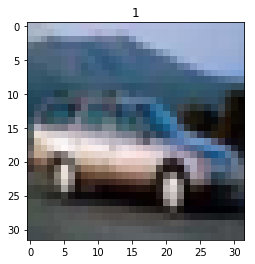

In [786]:
showImage(imagesByCategory[1][0], 1)

### Show low-dimensional reconstruction of original image 

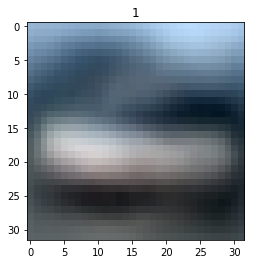

In [787]:
showImage(imagesByCategoryReconstructed[1][0], 1)

### Show mean image

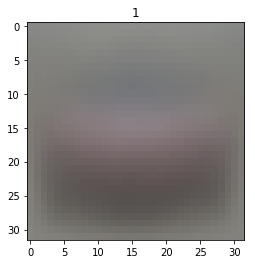

In [788]:
showImage(mean_images[1], 1) 

### Show low-dimensional reconstruction of mean image

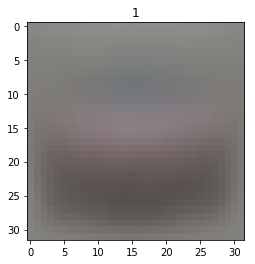

In [789]:
showImage(meanImagesByCategoryReconstructed[1], 1) 

## For each image, compute the squared difference between the original and reconstructed version, and sum this over all pixels over all channels.

In [790]:
sq_diff = np.zeros(10)

for i in range(0,10):
    sq_diff[i] = (np.linalg.norm(imagesByCategory[i]-imagesByCategoryReconstructed[i])) / 6000
    print ("Average of sums of squared difference for class", i, ":", sq_diff[i])

Average of sums of squared difference for class 0 : 116.245885503
Average of sums of squared difference for class 1 : 117.306311265
Average of sums of squared difference for class 2 : 117.916359741
Average of sums of squared difference for class 3 : 117.48550725
Average of sums of squared difference for class 4 : 118.774170146
Average of sums of squared difference for class 5 : 116.934423663
Average of sums of squared difference for class 6 : 118.782016351
Average of sums of squared difference for class 7 : 116.745160399
Average of sums of squared difference for class 8 : 117.254512375
Average of sums of squared difference for class 9 : 116.478027789


## Bar graph showing the squared difference for each class

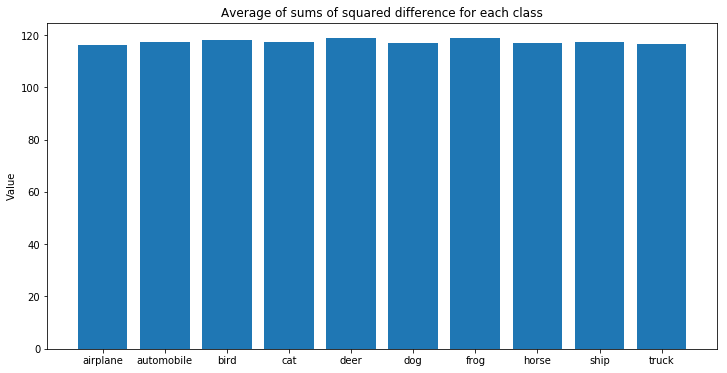

In [791]:
from matplotlib.pyplot import figure
figure(figsize=(12, 6))

y_pos = np.arange(len(label_names))
plt.bar(y_pos, sq_diff, align='center')
plt.xticks(y_pos, label_names)
plt.ylabel('Value')
plt.title('Average of sums of squared difference for each class')
plt.show()